<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Xarray with Dask Arrays

**ESDS dask tutorial | 06 February, 2023**  

Negin Sobhani, Brian Vanderwende, Deepak Cherian, Ben Kirk  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)

---------
### In this tutorial, you learn:

* Using Dask with Xarray
* Read/write netCDF files with Dask
* Dask backed Xarray objects and operations
* Extract Dask arrays from Xarray objects and use Dask array directly.


### Related Documentation

* [Xarray documentation](https://docs.xarray.dev/en/stable/)

---------

## Introduction

Xarray integrates with Dask to support parallel computations and streaming datasets that **don’t fit into memory.** Xarray can automatically wrap its data in dask arrays. 


## Setup: Spinning up a cluster

### Step1: Start a `dask` cluster

In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4)



2023-01-30 13:26:40,638 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-58dc4795', purging
2023-01-30 13:26:43,899 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-qzx7gjtc', purging
2023-01-30 13:26:48,277 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-j84tqltm', purging
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. (7.96s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


### Step2: Connect a client to it
Now we can connect client to it and watch the dashboard.

In [2]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42343,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:37696,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/workforce/proxy/33004/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:40997,


-----------
## Reading data with Dask and Xarray

### Reading multiple netCDF files with `open_mfdataset`

Xarray provides a function called `open_dataset` function that allows us to load a netCDF dataset into a Python data structure. To read more about this function, please see [xarray `open_dataset` API documentation](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html). 

Xarray also provides `open_mfdataset`, which open multiple files as a single xarray dataset. Passing the argument `parallel=True` will speed up reading multiple datasets by executing these tasks in parallel using Dask Delayed under the hood. 

In the example below, we open up multiple files using this function:

In [100]:
import os
import xarray as xr
import glob
xr.set_options(display_expand_data=False);

var = 'TREFHT'
# find all LENS files
data_dir = os.path.join('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/', var)
files = glob.glob(os.path.join(data_dir, 'b.e21.BSSP370smbb.f09_g17.LE2-1301.013*.nc'))

print("All files: [", len(files), "files]")

All files: [ 9 files]


In [24]:
%%time
ds = xr.open_mfdataset(
    sorted(files),
    concat_dim='ensemble_member',
    combine="nested",
    parallel=True,
    engine="netcdf4",
)
ds

CPU times: user 586 ms, sys: 37.2 ms, total: 623 ms
Wall time: 1.03 s


<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, lon: 288, lev: 32, ilev: 33, time: 1032,
                   ensemble_member: 9, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: ensemble_member, nbnd
Data variables: (12/27)
    zlon_bnds     (ensemble_member, zlon, nbnd) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    gw            (ensemble_member, lat) float64 dask.array<chunksize=(1, 192), meta=np.ndarray>
    hyam          (ensemble_member, lev) float64 dask.array<chunksize=(1, 32), meta=np.ndarray>
    hybm          (ensemble_member, lev) float64 dask.array<chunksize=(1, 32), meta=np.ndarray>
    P0            (ensemble_member) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (ensemble_member, ilev) float64 dask.array<chunksize=(1, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    f11vmr        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    f12vmr        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    sol_tsi       (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    nsteph        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    TREFHT        (ensemble_member, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370smbb.f09_g17.LE2-1301.013
    logname:           sunseon
    host:              mom1
    initial_file:      b.e21.BHISTsmbb.f09_g17.LE2-1301.013.cam.i.2015-01-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

Note that the "real" values are not displayed, since that would trigger actual computation.  
Xarray automatically wraps its object in Dask Arrays and Dask is lazy, meaning that operations are not computed until we explicitly request them (for example by calling `.compute()`). Please see previous notebooks for more information on "lazy evaluation". 

The represntation of `TREFHT` DataArray shows details of chunks and chunksizes of Xarray DataArray:

In [25]:
tref = ds.TREFHT
tref

<xarray.DataArray 'TREFHT' (ensemble_member: 9, time: 1032, lat: 192, lon: 288)>
dask.array<concatenate, shape=(9, 1032, 192, 288), dtype=float32, chunksize=(1, 1032, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: ensemble_member
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

* How many chunks do we have? 
* What is the size of each chunk size?


Here we can see that we have a total of 15 chunks equal to the number of our netCDF files. In general `open_mfdataset` will chunk each netCDF file into a single Dask array. By providing the `chunks` argument, we can control the size of the resulting Dask arrays. 


<div class="alert alert-block alert-warning">

<b>WARNING:</b> When `chunks` argument is not given to `open_mfdataset`,it will return dask arrays with chunk sizes equal to each netCDF file. Re-chunking the dataset after creation with ds.chunk() will lead to an ineffective use of memory and is not recommended.
</div>

In the example below, we call `open_mfdataset` to open multiple netCDF files and using the `chunks` argument to control the size of the resulting Dask arrays. 

In [32]:
#del ds
chunk_dict = { "lat": 96, "lon": 144}

In [28]:
%%time
ds = xr.open_mfdataset(
    sorted(files),
    concat_dim='time',
    combine="nested",
    parallel=True,
    engine="netcdf4",
    chunks=chunk_dict,
)
tref = ds.TREFHT
tref

CPU times: user 290 ms, sys: 14.7 ms, total: 305 ms
Wall time: 620 ms


<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<concatenate, shape=(1032, 192, 288), dtype=float32, chunksize=(120, 96, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [33]:
tref.chunks

((120, 120, 120, 120, 120, 120, 120, 120, 72), (96, 96), (288,))

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> The `chunks` parameter can significantly affect total performance when using Dask Arrays. `chunks` be small enough that each chunk fit in the memory, but large enough to avoid that the communication overhead. 

</div>

A good rule of thumb is to create arrays with a minimum chunksize of at least one million elements. Here we have 90*96*144 elements in each chunk.   
With large arrays (10+ GB), the cost of queueing up Dask operations can be noticeable, and you may need even larger chunksizes.

### Dask backed Xarray objects and operations

This means you can call the following Dask-related functions:

* `dask.visualize()`
* `dask.compute()`
* `dask.persist()`

on both xarray DataArrays and other datasets backed by Dask arrays. For more information abour Dask Arrays, please see the first notebook (****link).

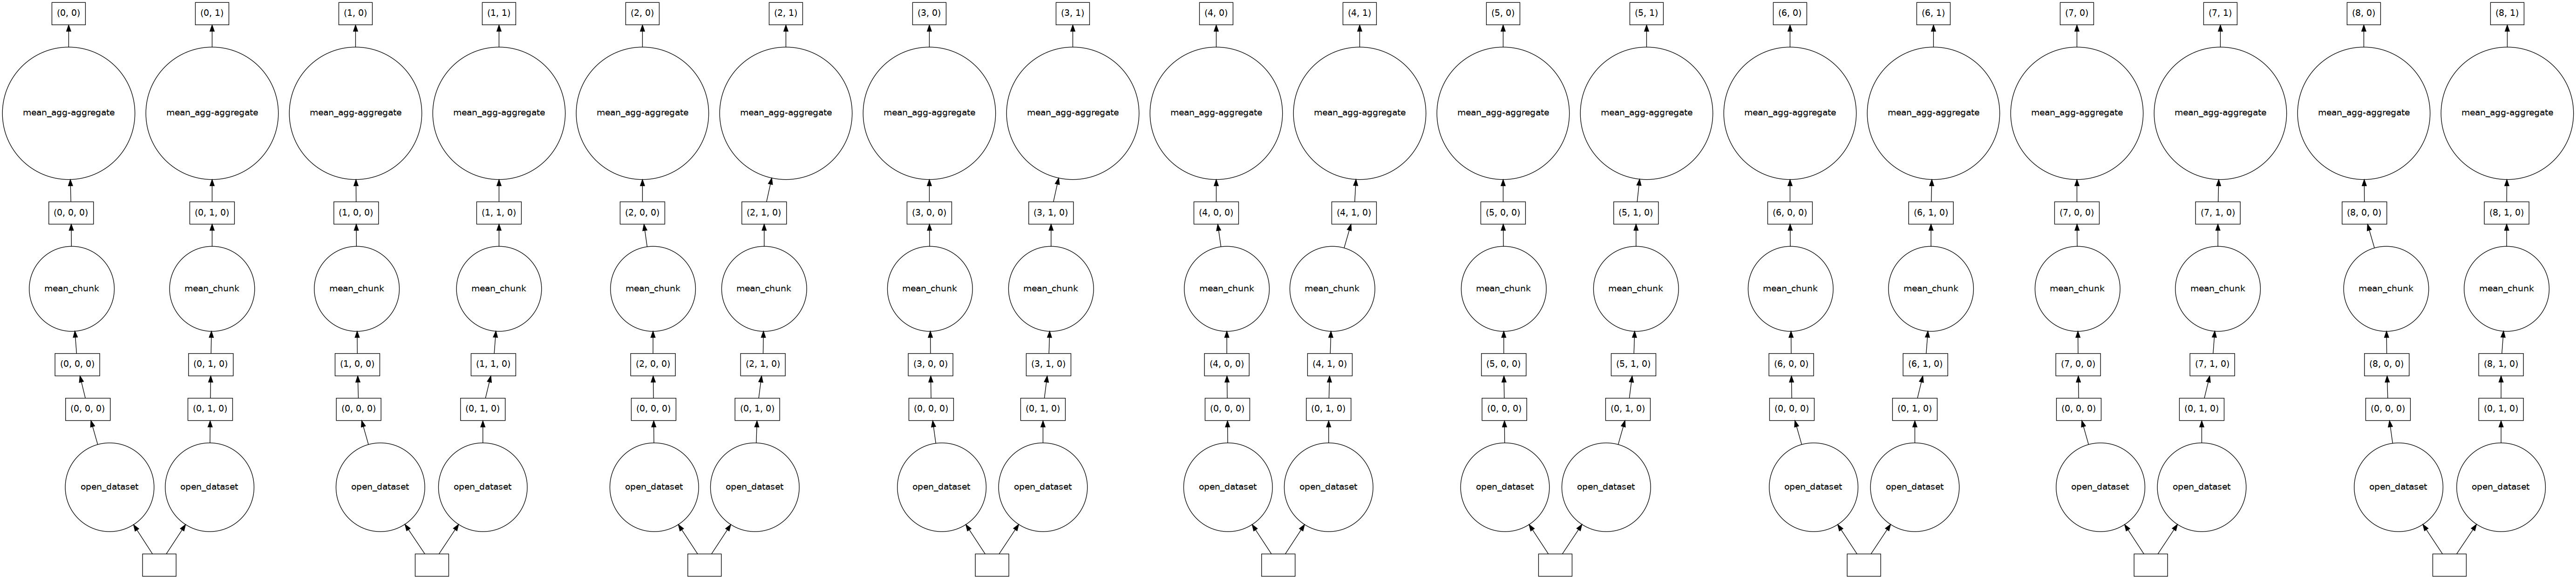

In [37]:
import dask
dask.visualize(tref.mean(axis=-1))

## How to access underlying data in an Xarray object?

There are two basic ways to extract values from an Xarray object:

1. Using `.data` will return a Dask array. For example:

In [38]:
tref.data

dask.array<concatenate, shape=(1032, 192, 288), dtype=float32, chunksize=(120, 96, 288), chunktype=numpy.ndarray>

**This means that for Dask-backed Xarray object, we can access the values using `.compute`**

2. We can also use `.values` to see the "real" values of Xarray object. Another option is using `.to_numpy`. Both of these option return the values of underlying Dask object in a numpy array. 

In [39]:
%%time
tref.to_numpy()

CPU times: user 271 ms, sys: 246 ms, total: 517 ms
Wall time: 2.59 s


array([[[248.39987, 248.39989, 248.39992, ..., 248.39989, 248.39989,
         248.39989],
        [248.95004, 248.9094 , 248.75017, ..., 248.98384, 248.97466,
         248.9626 ],
        [249.20784, 249.17082, 249.15718, ..., 249.42188, 249.37703,
         249.31105],
        ...,
        [251.5821 , 251.6182 , 251.65166, ..., 251.48357, 251.51555,
         251.54646],
        [251.34143, 251.35114, 251.36166, ..., 251.30699, 251.32008,
         251.3312 ],
        [251.35237, 251.35286, 251.35332, ..., 251.35059, 251.35123,
         251.35182]],

       [[237.44759, 237.44759, 237.44759, ..., 237.44759, 237.44759,
         237.44759],
        [238.10292, 238.05934, 237.8917 , ..., 238.16042, 238.14326,
         238.12119],
        [238.86865, 238.82155, 238.79092, ..., 239.1196 , 239.04976,
         238.96754],
        ...,
        [246.23404, 246.25865, 246.28221, ..., 246.15912, 246.18312,
         246.20715],
        [246.70511, 246.7112 , 246.71793, ..., 246.68782, 246.69476,
   

## Computation

Now, let's do some computations on this Xarray dataset. 

### Single Point Calculations

To start out, let's do the calculations on a single point first. First, we extract the time series data at a grid point and save it to a variable. Here we select the closest point using `.sel` and load the data. 

In [40]:
tref_boulder = tref.sel(lat=40.0150, lon=-105.2705, method='nearest').load()


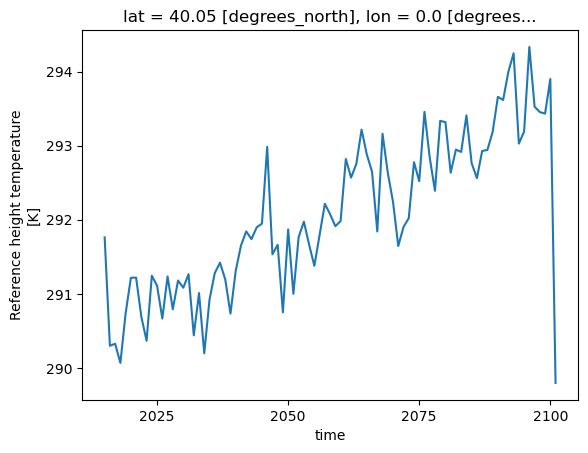

In [46]:
tref_boulder.resample(time='AS').mean().plot()

### Calculations over all grids

In [47]:
%%time

# Compute monthly anomaly
gb = tref.groupby('time.month')
tmean = gb.mean(dim='time')
tos_anom = gb - tmean
tos_anom

CPU times: user 55.1 ms, sys: 0 ns, total: 55.1 ms
Wall time: 65.1 ms


/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]


<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<sub, shape=(1032, 192, 288), dtype=float32, chunksize=(1, 96, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

Dask actually constructs a graph of the required computation.

In [50]:
#dask.visualize(tos_anom.data, rankdir="LR")

Call `.compute()` or `.load()` when you want your result as a xarray.DataArray to access underlying dataset:
* `.compute() ` works similarly here as Dask DataArray. It basically triggers the computations across different chunks of the DataArray. 
* `.load()` replaces the dask array in the Xarray object with a numpy array. 

In [51]:
%%time
computed_anom = tos_anom.load()
type(computed_anom)

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2b8c2ee81ca0>>
Traceback (most recent call last):
  File "/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/distributed/utils_perf.py", line 189, in _gc_callback
    self._fractional_timer.start_timing()
  File "/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/distributed/utils_perf.py", line 116, in start_timing
    assert self._cur_start is None
AssertionError: 


CPU times: user 3.98 s, sys: 404 ms, total: 4.39 s
Wall time: 17.3 s


xarray.core.dataarray.DataArray

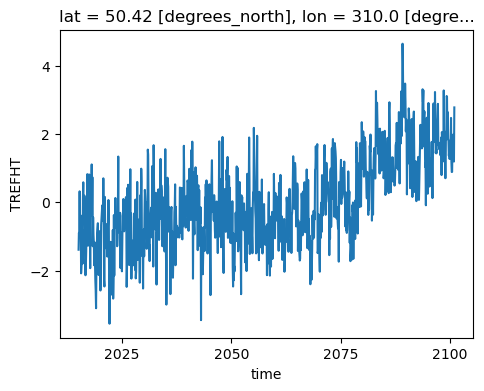

In [53]:
tos_anom.sel(lon=310, lat=50, method='nearest').plot( size=4)

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> Using Xarray plotting functionality automatically triggers computations on the Dask Array, similar to `.compute()`.

</div>

In [82]:
# change the unit from Kelvin to degree Celsius 

tref_c = tref- 273.15
tref_c

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<sub, shape=(1032, 192, 288), dtype=float32, chunksize=(90, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

In [83]:
# Untile we explicitly call load() or compute(), Dask actually didn't do any real calculation
# We are doing the calculations below parallelly. However not much benefit from parallel computing since it's not a big problem
%time tref_c=tref_c.load()

CPU times: user 258 ms, sys: 271 ms, total: 529 ms
Wall time: 3.35 s


### Rechunking

We can always rechunk an Xarray DataArray. For example, what is the chunk size of `tref`?

In [84]:
tref

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<rechunk-merge, shape=(1032, 192, 288), dtype=float32, chunksize=(90, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

Is this a good chunk size?

In [86]:
chunk_dict = {"time":90, "lat": 192, "lon": 288}
tref = tref.chunk(chunk_dict)
tref

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<rechunk-merge, shape=(1032, 192, 288), dtype=float32, chunksize=(90, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

We can do more complex calculations too:

In [87]:
rolling_mean = tref.rolling(time=5).mean()
rolling_mean  # contains dask array

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<truediv, shape=(1032, 192, 288), dtype=float32, chunksize=(94, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [88]:
timeseries = rolling_mean.isel(lon=1, lat=20)  # no activity on dashboard
timeseries  # contains dask array

<xarray.DataArray 'TREFHT' (time: 1032)>
dask.array<getitem, shape=(1032,), dtype=float32, chunksize=(94,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 -71.15
    lon      float64 1.25
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [89]:
computed = rolling_mean.compute()  # activity on dashboard
computed  # has real numpy values

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [273.74554, 273.74554, 273.74585, ..., 273.74713, 273.7464 ,
         273.74585],
        [273.8277 , 273.8276 , 273.8277 , ..., 273.82904, 273.82837,
         273.82794],
        [273.91922, 273.91898, 273.91876, ..., 273.92017, 273.91986,
         273.9195 ]],

       [[232.90976, 232.90982, 232.90984, ..., 232.90979, 232.90979,
         232.90979],
        [233.47034, 233.4355 , 233.28328, ..., 233.49512, 233.49011,
         233.48125],
        [233.8564 , 233.81363, 233.79611, ..., 234.08301, 234.03255,
         233.96402],
        ...,
        [273.20447, 273.2046 , 273.2051 , ..., 273.20523, 273.20477,
         273.20453],
        [273.29013, 273.28958, 273.28906, ..., 273.2929 , 273.29178,
         273.29086],
        [273.3635 , 273.36328, 273.36313, ..., 273.36423, 273.36398,
         273.3637 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

### Advanced workflows and automatic parallelization using `apply_ufunc`
Most of xarray’s built-in operations work on Dask arrays. If you want to use a function that isn’t wrapped by Xarray to work with Dask, one option is to extract Dask arrays from xarray objects (.data) and use Dask directly.

Another option is to use xarray’s `apply_ufunc()` function. `xr.apply_ufunc()` can automate embarrassingly parallel “map” type operations where a function written for processing NumPy arrays, but we want to apply it on our Xarray DataArray. 

`xr.apply_ufunc()` give users capability to run custom-written functions such as parameter calculations in a parallel way. 

In the example below, we calculate the saturation vapor pressure by using `apply_unfunc()` to apply this function to our Dask Array chunk by chunk. 

In [74]:
import numpy as np
# return saturation vapor pressure
# using Clausius-Clapeyron equation
def sat_p(t):
    return 0.611*np.exp(17.67*(t-273.15)*((t-29.65)**(-1)))

In [90]:
es=xr.apply_ufunc(sat_p,tref,dask="parallelized",output_dtypes=[float])


In [91]:
es

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<transpose, shape=(1032, 192, 288), dtype=float64, chunksize=(90, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

In [93]:
es.compute()

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
array([[[0.08275229, 0.08275241, 0.08275262, ..., 0.08275241,
         0.08275241, 0.08275241],
        [0.08693817, 0.08662252, 0.08539595, ..., 0.08720139,
         0.08712979, 0.08703589],
        [0.08896421, 0.0886707 , 0.08856276, ..., 0.09067844,
         0.09031681, 0.08978716],
        ...,
        [0.10971484, 0.11006118, 0.11038325, ..., 0.10877403,
         0.10907856, 0.10937367],
        [0.10742975, 0.10752106, 0.10762019, ..., 0.10710629,
         0.10722913, 0.10733365],
        [0.10753268, 0.10753729, 0.1075416 , ..., 0.10751589,
         0.10752192, 0.10752752]],

       [[0.02934595, 0.02934595, 0.02934595, ..., 0.02934595,
         0.02934595, 0.02934595],
        [0.03131977, 0.03118489, 0.03067086, ..., 0.03149854,
         0.03144512, 0.03137647],
        [0.03377749, 0.03362142, 0.0335203 , ..., 0.03462001,
         0.03438365, 0.03410727],
...
        [0.554945  , 0.5548357 , 0.5547661 , ..., 0.5553588 ,
         0.55520225, 0.5550743 ],
        [0.56466943, 0.56459117, 0.564518  , ..., 0.56499124,
         0.5648814 , 0.56476784],
        [0.57361263, 0.5735934 , 0.5735768 , ..., 0.5736842 ,
         0.57365733, 0.5736343 ]],

       [[0.09778247, 0.09778459, 0.09778577, ..., 0.09778367,
         0.09778367, 0.09778326],
        [0.10507483, 0.10480616, 0.10343715, ..., 0.10523223,
         0.10518716, 0.10514309],
        [0.11029152, 0.10999992, 0.10992679, ..., 0.11217107,
         0.11179078, 0.11121714],
        ...,
        [0.5327586 , 0.5328329 , 0.5329144 , ..., 0.53256935,
         0.5326304 , 0.5326939 ],
        [0.53325725, 0.5332873 , 0.533316  , ..., 0.53317934,
         0.5331973 , 0.5332273 ],
        [0.5323095 , 0.53231186, 0.53231424, ..., 0.5323011 ,
         0.5323047 , 0.5323071 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

The data used for this tutorial is from one ensemble member. What if we want to use multiple ensemble members? `dask.distributed`

### Dask + Xarray Good Practices:

The good practices regarding Dask + Xarray is the same as the good practices for Dask only.

* Similar to Dask DataFrames, it is more efficient to first do spatial and temporal indexing (e.g. .sel() or .isel()) and filter the dataset early in the pipeline, especially before calling resample() or groupby(). 

* Chunk sizes should be small enough to fit into the memory at once but large enough to avoid the additional communication overhead. Good chunk size ~100 MB. 

* It is always better to chunk along the `time` dimension. 

* Avoid too many tasks since each task will introduce 1ms of overhead. 

* When possible, use `xr.apply_ufunc` to apply an unvectorized function to the Xarray object. 


### Close you local Dask Cluster
It is always a good practice to close the Dask cluster you created.

In [101]:
client.shutdown()

## Summary:

In this notebook, we have learned about:

* Using Dask with Xarray
* Read/write netCDF files with Dask
* Dask backed Xarray objects and operations
* Extract Dask arrays from Xarray objects and use Dask array directly..
* Customized workflows using `apply_ufunc`

## Resources and references

* Reference
    *  [Dask Docs](https://dask.org/)
    *  [Dask Examples](https://examples.dask.org/)
    *  [Dask Code](https://github.com/dask/dask/)
    *  [Dask Blog](https://blog.dask.org/)
    
    *  [Xarray Docs](https://xarray.pydata.org/)
  
*  Ask for help
    *   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
    *   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
     *   [github discussions: xarray](https://github.com/pydata/xarray/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: xarray](https://github.com/pydata/xarray/issues/new) for bug reports and feature requests